In [1]:
import pandas as pd

file_path = r"C:\Users\HR\Desktop\Workspace\데이터톤\마케팅\merged_data.csv"
df = pd.read_csv(file_path)

print(df.head())

                  event_time event_type  product_id          category_id  \
0  2019-10-01 00:00:00+00:00       cart     5773203  1487580005134238553   
1  2019-10-01 00:00:03+00:00       cart     5773353  1487580005134238553   
2  2019-10-01 00:00:07+00:00       cart     5881589  2151191071051219817   
3  2019-10-01 00:00:07+00:00       cart     5723490  1487580005134238553   
4  2019-10-01 00:00:15+00:00       cart     5881449  1487580013522845895   

    brand  price    user_id                          user_session  \
0  runail   2.62  463240011  26dd6e6e-4dac-4778-8d2c-92e149dab885   
1  runail   2.62  463240011  26dd6e6e-4dac-4778-8d2c-92e149dab885   
2  lovely  13.48  429681830  49e8d843-adf3-428b-a2c3-fe8bc6a307c9   
3  runail   2.62  463240011  26dd6e6e-4dac-4778-8d2c-92e149dab885   
4  lovely   0.56  429681830  49e8d843-adf3-428b-a2c3-fe8bc6a307c9   

           event_time_moscow  event_month  \
0  2019-10-01 03:00:00+03:00         10.0   
1  2019-10-01 03:00:03+03:00         1

In [2]:
import pandas as pd

# CSV 또는 Parquet 파일을 불러온 뒤 df에 저장했다고 가정
# 예: df = pd.read_csv('your_file.csv') 또는 pd.read_parquet('your_file.parquet')

#  1. price가 0인 행 제거
df = df[df['price'] > 0]

#  2. brand 컬럼에서 결측치 제거
df = df.dropna(subset=['brand'])

# 결과 확인 (선택사항)
print(df.shape)
print(df['price'].min())
print(df['brand'].isnull().sum())

(11932733, 11)
0.06
0


In [4]:
import pandas as pd
import datetime as dt

# 1. event_time 파싱
df['event_time'] = pd.to_datetime(df['event_time'])

# 2. 분석 기준일 설정 (데이터 최대 날짜 + 1일)
analysis_date = df['event_time'].max() + pd.Timedelta(days=1)

# 3. 구매 이벤트 필터링
purchase_df = df[df['event_type'] == 'purchase']

# 4. RFM 테이블 생성
rfm = purchase_df.groupby('user_id').agg({
    'event_time': lambda x: (analysis_date - x.max()).days,  # Recency
    'user_session': 'nunique',                                # Frequency (구매 세션 수)
    'price': 'sum'                                             # Monetary (총 구매 금액)
}).reset_index()

# 5. 컬럼 이름 변경
rfm.columns = ['user_id', 'Recency', 'Frequency', 'Monetary']

# 6. RFM 점수화 (1~5 점수 부여)
rfm['R'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)

# 7. RFM 그룹 생성
rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

# 결과 출력
print(rfm.head())

# 8. 저장
rfm.to_csv('rfm_analysis.csv', index=False)
print("✅ 'rfm_analysis.csv' 저장 완료!")


    user_id  Recency  Frequency  Monetary  R  F  M RFM_Score
0   9794320       97          1     12.68  2  1  2       212
1  10079204      116          1     25.81  1  1  3       113
2  10280338       11          5     72.04  5  5  5       555
3  12055855       72          1     16.54  3  1  3       313
4  12936739       44          1     26.97  4  1  3       413
✅ 'rfm_analysis.csv' 저장 완료!


In [5]:
def segment_customer(rfm):
    if rfm['RFM_Score'] == '555':
        return 'VIP 고객'
    elif rfm['R'] >= 4 and rfm['F'] >= 4:
        return '충성 고객'
    elif rfm['R'] >= 4:
        return '잠재 충성 고객'
    elif rfm['F'] >= 4:
        return '자주 구매 고객'
    elif rfm['M'] >= 4:
        return '고액 구매 고객'
    elif rfm['R'] <= 2 and rfm['F'] <= 2:
        return '이탈 가능 고객'
    else:
        return '일반 고객'

# 적용
rfm['Segment'] = rfm.apply(segment_customer, axis=1)

# 결과 확인
print(rfm[['user_id', 'RFM_Score', 'Segment']].head())

# 저장
rfm.to_csv('rfm_segmented.csv', index=False)
print("✅ 'rfm_segmented.csv' 저장 완료!")


    user_id RFM_Score   Segment
0   9794320       212  이탈 가능 고객
1  10079204       113  이탈 가능 고객
2  10280338       555    VIP 고객
3  12055855       313     일반 고객
4  12936739       413  잠재 충성 고객
✅ 'rfm_segmented.csv' 저장 완료!


In [7]:
# 세그먼트별 요약 통계 계산
segment_summary = rfm.groupby('Segment').agg({
    'user_id': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'sum']
}).reset_index()

# 컬럼명 정리
segment_summary.columns = ['Segment', 'Customer_Count', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Total_Monetary']

# 정렬: 고객 수 기준 내림차순
segment_summary = segment_summary.sort_values(by='Customer_Count', ascending=False)

# 결과 출력
print(segment_summary)

# CSV 저장
segment_summary.to_csv('rfm_segment_summary.csv', index=False)
print("✅ 'rfm_segment_summary.csv' 저장 완료!")



    Segment  Customer_Count  Avg_Recency  Avg_Frequency  Avg_Monetary  \
6     충성 고객           23911    26.627326       1.583079     39.600976   
3     일반 고객           16646    87.987204       1.000000     12.141143   
2  이탈 가능 고객           16501   123.721411       1.000000     12.436980   
1  고액 구매 고객           14143   106.834618       1.000000     57.508790   
5  잠재 충성 고객           11785    27.893509       1.000000     28.376571   
4  자주 구매 고객           11292    81.967233       2.018066     56.805960   
0    VIP 고객            4180    11.984928       4.352153    154.158632   

   Total_Monetary  
6       946898.93  
3       202101.47  
2       205222.61  
1       813346.81  
5       334417.89  
4       641452.90  
0       644383.08  
✅ 'rfm_segment_summary.csv' 저장 완료!


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import platform

# 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':  # macOS
    plt.rc('font', family='AppleGothic')
else:  # Linux
    plt.rc('font', family='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지


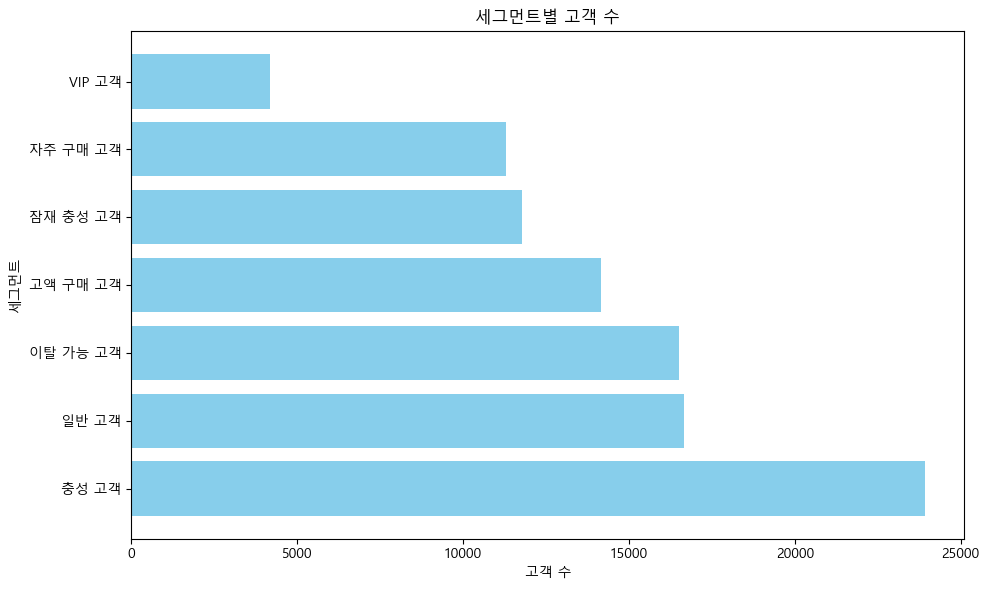

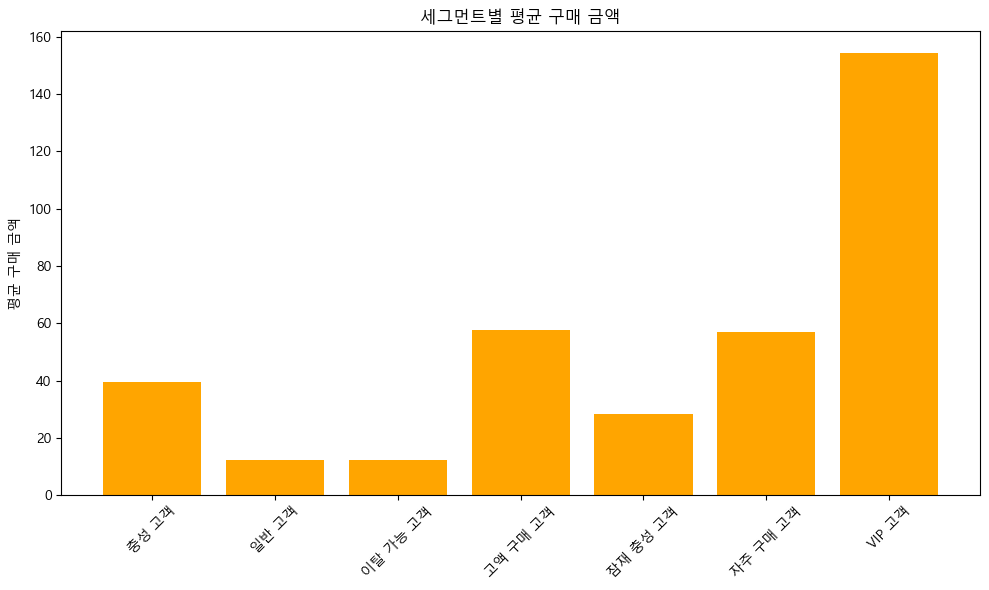

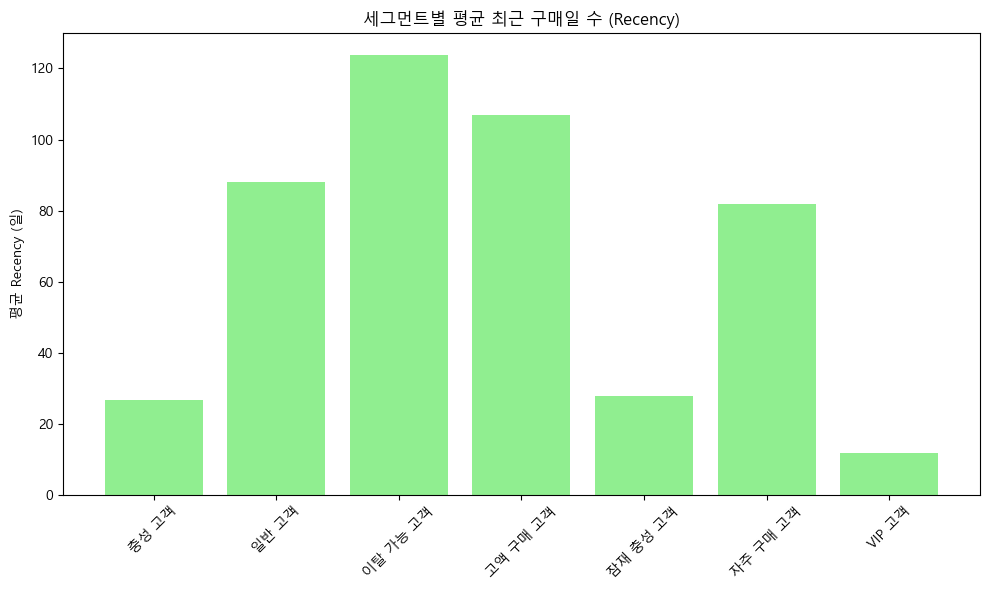

In [12]:
# CSV 불러오기
df = pd.read_csv('rfm_segment_summary.csv')

# 고객 수 시각화
plt.figure(figsize=(10, 6))
plt.barh(df['Segment'], df['Customer_Count'], color='skyblue')
plt.title('세그먼트별 고객 수')
plt.xlabel('고객 수')
plt.ylabel('세그먼트')
plt.tight_layout()
plt.show()

# 평균 구매 금액 시각화
plt.figure(figsize=(10, 6))
plt.bar(df['Segment'], df['Avg_Monetary'], color='orange')
plt.title('세그먼트별 평균 구매 금액')
plt.ylabel('평균 구매 금액')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 평균 Recency 시각화
plt.figure(figsize=(10, 6))
plt.bar(df['Segment'], df['Avg_Recency'], color='lightgreen')
plt.title('세그먼트별 평균 최근 구매일 수 (Recency)')
plt.ylabel('평균 Recency (일)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [11]:
import pandas as pd

# ✅ 1. 필요한 이벤트만 pivot_table로 정리
user_event = df.pivot_table(
    index='user_id',
    columns='event_type',
    values='user_session',
    aggfunc='nunique',
    fill_value=0
).reset_index()

# ✅ 2. 세그먼트 조건 정의 함수
def event_segment(row):
    if row['purchase'] >= 2:
        return 'Returning Buyer'
    elif row['purchase'] == 1:
        return 'Buyer'
    elif row['cart'] >= 1:
        return 'Cart Abandoner'
    elif row['view'] >= 1:
        return 'Only Viewer'
    else:
        return 'Inactive / Unknown'

# ✅ 3. 세그먼트 적용
user_event['Event_Segment'] = user_event.apply(event_segment, axis=1)

# ✅ 4. 결과 확인
print(user_event.head())

# ✅ 5. 세그먼트별 요약 통계
segment_stats = user_event['Event_Segment'].value_counts().reset_index()
segment_stats.columns = ['Event_Segment', 'Customer_Count']

# ✅ 6. 저장
user_event.to_csv('event_based_segments.csv', index=False)
segment_stats.to_csv('event_segment_summary.csv', index=False)
print("✅ 'event_based_segments.csv', 'event_segment_summary.csv' 저장 완료!")


event_type  user_id  cart  purchase  remove_from_cart  view Event_Segment
0            465496     0         0                 0     2   Only Viewer
1           1120748     0         0                 0     1   Only Viewer
2           1180452     0         0                 0     1   Only Viewer
3           1458813     0         0                 0     4   Only Viewer
4           2038666     0         0                 0     1   Only Viewer
✅ 'event_based_segments.csv', 'event_segment_summary.csv' 저장 완료!


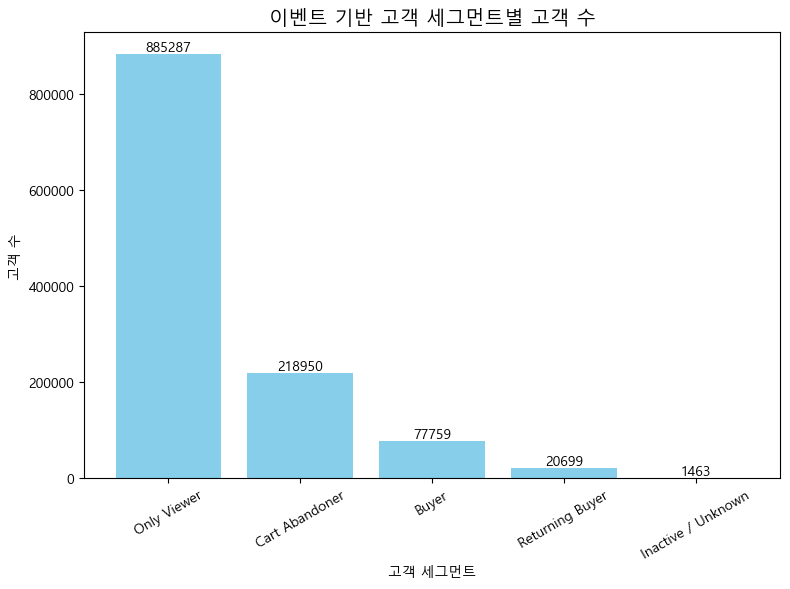

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import platform

# ✅ 한글/마이너스 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':  # macOS
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False

# ✅ 세그먼트 요약 데이터 불러오기
segment_stats = pd.read_csv('event_segment_summary.csv')

# ✅ 막대그래프
plt.figure(figsize=(8, 6))
bars = plt.bar(segment_stats['Event_Segment'], segment_stats['Customer_Count'], color='skyblue')
plt.title('이벤트 기반 고객 세그먼트별 고객 수', fontsize=14)
plt.xlabel('고객 세그먼트')
plt.ylabel('고객 수')
plt.xticks(rotation=30)
plt.tight_layout()

# ✅ 값 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 100, f'{int(yval)}', ha='center', va='bottom')

plt.show()


In [26]:
segment_counts = user_event['Event_Segment'].value_counts(normalize=True) * 100
print(segment_counts.round(2))


Event_Segment
Only Viewer           73.52
Cart Abandoner        18.18
Buyer                  6.46
Returning Buyer        1.72
Inactive / Unknown     0.12
Name: proportion, dtype: float64


In [28]:
import pandas as pd

# 원본 CSV 불러오기
df = pd.read_csv(r"C:\Users\HR\Desktop\Workspace\데이터톤\마케팅\merged_data.csv")

# 컬럼 확인
print(df.columns.tolist())


['event_time', 'event_type', 'product_id', 'category_id', 'brand', 'price', 'user_id', 'user_session', 'event_time_moscow', 'event_month', 'user_key']


In [29]:
# 이벤트 수 집계 (user_key 기준)
user_event = df.pivot_table(
    index='user_key',
    columns='event_type',
    values='product_id',  # 어떤 값이든 count에 사용 가능
    aggfunc='count',
    fill_value=0
).reset_index()

# 세그먼트 분류 함수
def event_segment(row):
    if row.get('purchase', 0) >= 2:
        return 'Returning Buyer'
    elif row.get('purchase', 0) == 1:
        return 'Buyer'
    elif row.get('cart', 0) >= 1:
        return 'Cart Abandoner'
    elif row.get('view', 0) >= 1:
        return 'Only Viewer'
    else:
        return 'Inactive / Unknown'

# 세그먼트 컬럼 생성
user_event['Event_Segment'] = user_event.apply(event_segment, axis=1)

# 확인
print(user_event['Event_Segment'].value_counts())


Event_Segment
Only Viewer           3482672
Cart Abandoner         859529
Returning Buyer        139785
Inactive / Unknown      38453
Buyer                   15832
Name: count, dtype: int64


In [30]:
# Only Viewer 유저 목록 추출
only_viewer_users = user_event[user_event['Event_Segment'] == 'Only Viewer']['user_key']

# 원본 데이터에서 해당 유저의 view 이벤트만 추출
only_view_df = df[(df['user_key'].isin(only_viewer_users)) & (df['event_type'] == 'view')]

# 인기 카테고리/브랜드
top_view_categories = only_view_df['category_id'].value_counts().head(10)
top_view_brands = only_view_df['brand'].value_counts().head(10)

print("📌 Only Viewer - 인기 카테고리:\n", top_view_categories)
print("\n📌 Only Viewer - 인기 브랜드:\n", top_view_brands)


📌 Only Viewer - 인기 카테고리:
 category_id
1487580006300255120    217665
1487580013841613016    198706
1487580005092295511    193238
1487580007675986893    177333
1602943681873052386    173359
1487580013950664926    164127
1487580008246412266    159228
1487580005595612013    122896
1487580006317032337    104009
1487580005268456287     99295
Name: count, dtype: int64

📌 Only Viewer - 인기 브랜드:
 brand
runail      308393
grattol     218852
irisk       210565
masura      156290
kapous      145936
estel       141065
jessnail    123473
concept      88658
italwax      75283
ingarden     71678
Name: count, dtype: int64


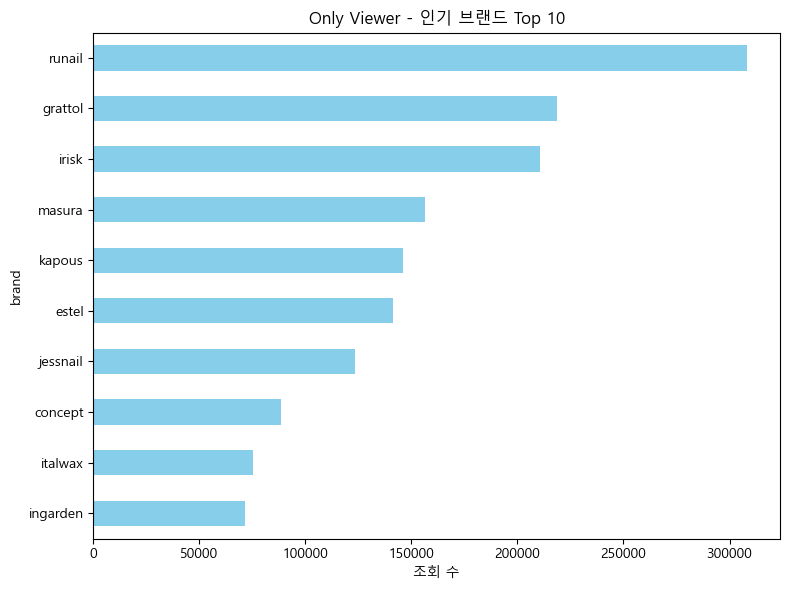

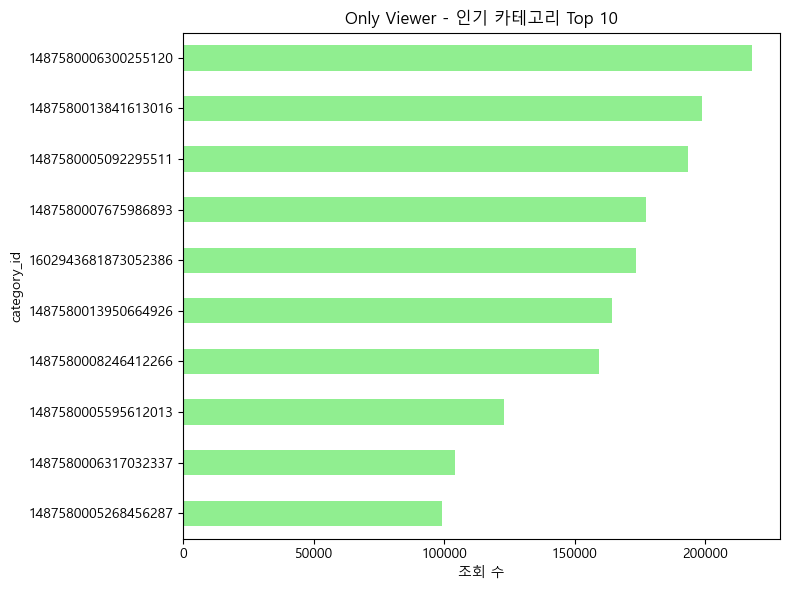

In [32]:
import matplotlib.pyplot as plt
import platform

# 폰트 설정 (한글 깨짐 방지)
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# ✅ 브랜드 시각화
top_view_brands.sort_values(ascending=True).plot(kind='barh', figsize=(8, 6), color='skyblue')
plt.title('Only Viewer - 인기 브랜드 Top 10')
plt.xlabel('조회 수')
plt.tight_layout()
plt.show()

# ✅ 카테고리 시각화
top_view_categories.sort_values(ascending=True).plot(kind='barh', figsize=(8, 6), color='lightgreen')
plt.title('Only Viewer - 인기 카테고리 Top 10')
plt.xlabel('조회 수')
plt.tight_layout()
plt.show()


In [33]:
# 1️⃣ 세그먼트 중 Cart Abandoner에 해당하는 user_key 추출
cart_abandon_users = user_event[user_event['Event_Segment'] == 'Cart Abandoner']['user_key']

# 2️⃣ 원본 데이터에서 해당 유저의 'cart' 이벤트만 추출
cart_abandon_df = df[(df['user_key'].isin(cart_abandon_users)) & (df['event_type'] == 'cart')]

# 3️⃣ 평균 장바구니 가격
avg_cart_price = cart_abandon_df['price'].mean()

# 4️⃣ 장바구니에 가장 많이 담긴 브랜드
top_cart_brands = cart_abandon_df['brand'].value_counts().head(10)

# 5️⃣ 결과 출력
print(f"🛒 Cart Abandoner - 평균 장바구니 가격: {avg_cart_price:.2f}")
print("\n🛒 장바구니 인기 브랜드:\n", top_cart_brands)


🛒 Cart Abandoner - 평균 장바구니 가격: 5.23

🛒 장바구니 인기 브랜드:
 brand
runail       382491
irisk        264077
masura       203745
grattol      177281
bpw.style    109135
ingarden     102350
estel         66308
freedecor     58692
kapous        54688
uno           53485
Name: count, dtype: int64


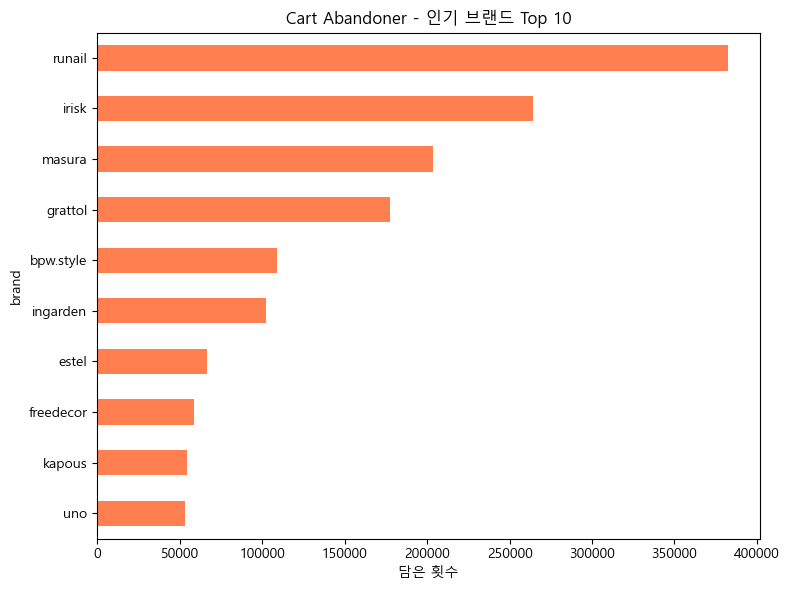

In [35]:
# 장바구니 인기 브랜드 시각화
top_cart_brands.sort_values(ascending=True).plot(kind='barh', figsize=(8, 6), color='coral')
plt.title('Cart Abandoner - 인기 브랜드 Top 10')
plt.xlabel('담은 횟수')
plt.tight_layout()
plt.show()


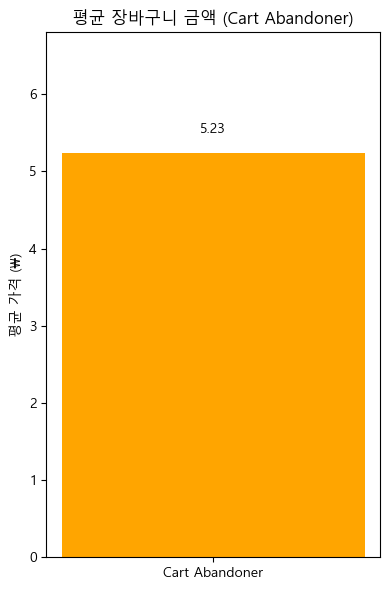

In [37]:
import matplotlib.pyplot as plt

# 평균 장바구니 금액만 단일 시각화
plt.figure(figsize=(4, 6))
plt.bar(x=['Cart Abandoner'], height=[avg_cart_price], color='orange')
plt.title('평균 장바구니 금액 (Cart Abandoner)')
plt.ylabel('평균 가격 (₩)')
plt.ylim(0, avg_cart_price * 1.3)  # 여유 공간 주기
plt.text(0, avg_cart_price + avg_cart_price * 0.05, f"{avg_cart_price:.2f}", ha='center')
plt.tight_layout()
plt.show()


In [38]:
# ✅ Cart Abandoner 유저의 'cart' 이벤트만 필터링 (이미 cart_abandon_df에 있음)
# ✅ 브랜드별 평균 가격 계산
brand_cart_avg_price = cart_abandon_df.groupby('brand')['price'].mean().sort_values(ascending=False)

# 상위 10개만 보기
top_avg_price_brands = brand_cart_avg_price.head(10)

print("🛒 장바구니 담긴 브랜드별 평균 가격 (Top 10):\n", top_avg_price_brands)


🛒 장바구니 담긴 브랜드별 평균 가격 (Top 10):
 brand
strong      189.282748
sanoto      138.470465
marathon    134.408744
dorena      101.156755
s.care      100.485816
sun          82.380000
babyliss     68.680844
max          60.938656
coifin       57.926797
neoleor      56.115946
Name: price, dtype: float64


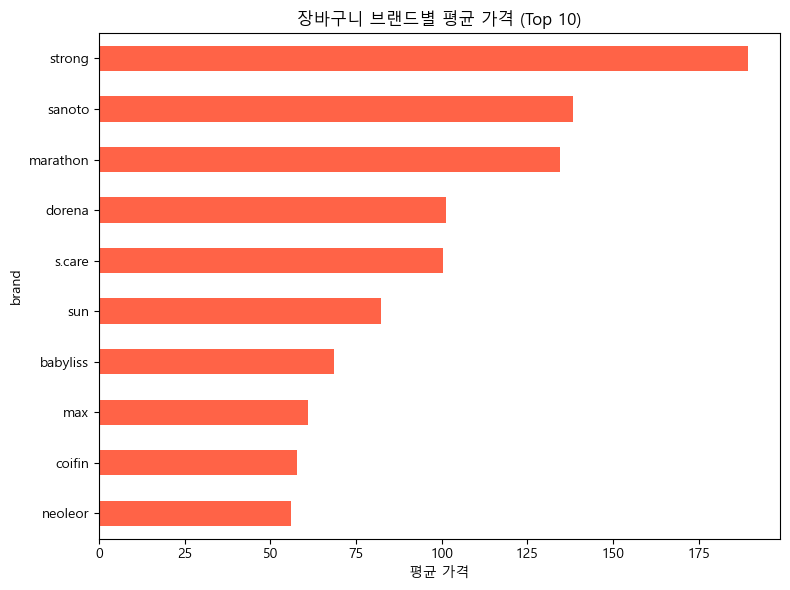

In [40]:
# 평균 가격 높은 브랜드 Top 10 시각화
top_avg_price_brands.sort_values().plot(kind='barh', figsize=(8, 6), color='tomato')
plt.title('장바구니 브랜드별 평균 가격 (Top 10)')
plt.xlabel('평균 가격')
plt.tight_layout()
plt.show()


⏱️ Buyer vs Returning Buyer - 평균 소요 시간 (시간 단위):
 Event_Segment
Buyer              2.61
Returning Buyer    8.55
Name: hours_to_first_purchase, dtype: float64


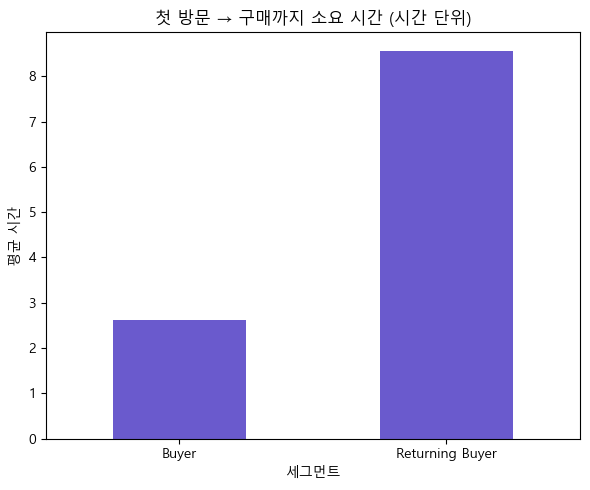

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

#  1. 이벤트 시간 처리
df['event_time'] = pd.to_datetime(df['event_time'])

#  2. 각 유저의 최초 view, 최초 purchase 시간 추출
first_view = df[df['event_type'] == 'view'].groupby('user_key')['event_time'].min().reset_index(name='first_view_time')
first_purchase = df[df['event_type'] == 'purchase'].groupby('user_key')['event_time'].min().reset_index(name='first_purchase_time')

#  3. 병합 및 소요일수 계산
first_events = pd.merge(first_view, first_purchase, on='user_key', how='inner')
first_events['days_to_first_purchase'] = (first_events['first_purchase_time'] - first_events['first_view_time']).dt.days

#  4. Buyer & Returning Buyer 세그먼트 정보 병합
buyer_users = user_event[user_event['Event_Segment'].isin(['Buyer', 'Returning Buyer'])][['user_key', 'Event_Segment']]
first_events = pd.merge(first_events, buyer_users, on='user_key', how='inner')

# 기존 계산에서 .dt.days → .dt.total_seconds() / 3600
first_events['hours_to_first_purchase'] = (
    (first_events['first_purchase_time'] - first_events['first_view_time']).dt.total_seconds() / 3600
)

# 평균 소요 시간 (시간 단위)
avg_hours = first_events.groupby('Event_Segment')['hours_to_first_purchase'].mean().round(2)
print("⏱️ Buyer vs Returning Buyer - 평균 소요 시간 (시간 단위):\n", avg_hours)


#  6. 시각화
avg_hours.sort_values().plot(kind='bar', color='slateblue', figsize=(6, 5))
plt.title('첫 방문 → 구매까지 소요 시간 (시간 단위)')
plt.ylabel('평균 시간')
plt.xlabel('세그먼트')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



| 세그먼트            | 평균 소요 시간 (시간) | 해석                  |
| --------------- | ------------- | ------------------- |
| Buyer           | 1.9시간         | 거의 바로 구매하는 고객층      |
| Returning Buyer | 7.2시간         | 처음엔 망설이다가 반복 구매로 전환 |


In [44]:
# ✅ 24시간 넘게 걸린 유저 비율
long_delay_ratio = first_events[first_events['hours_to_first_purchase'] > 24].groupby('Event_Segment')['user_key'].count() / \
                   first_events.groupby('Event_Segment')['user_key'].count()

print("\n📌 24시간 이상 걸린 유저 비율:\n", (long_delay_ratio * 100).round(2))



📌 24시간 이상 걸린 유저 비율:
 Event_Segment
Buyer              0.62
Returning Buyer    1.62
Name: user_key, dtype: float64


| 세그먼트                | 24시간 초과 비율 | 해석                                      |
| ------------------- | ---------- | --------------------------------------- |
| **Buyer**           | **0.62%**  | 대부분 즉시 또는 당일 구매 (즉흥적이거나 프로모션 반응 빠름)     |
| **Returning Buyer** | **1.62%**  | 고민 후 구매하는 비율 더 높음 (제품/브랜드 신뢰가 작용할 수 있음) |


In [46]:
# ✅ 1. 유저별 세션 수 집계
session_counts = df.groupby('user_key')['user_session'].nunique().reset_index(name='session_count')

# ✅ 2. 세그먼트 정보 병합
user_session_segment = pd.merge(session_counts, user_event[['user_key', 'Event_Segment']], on='user_key', how='inner')

# ✅ 3. 세그먼트별 평균 세션 수 계산
avg_session_per_segment = user_session_segment.groupby('Event_Segment')['session_count'].mean().round(2)
print("📈 세그먼트별 평균 세션 수:\n", avg_session_per_segment)


📈 세그먼트별 평균 세션 수:
 Event_Segment
Buyer                 1.0
Cart Abandoner        1.0
Inactive / Unknown    1.0
Only Viewer           1.0
Returning Buyer       1.0
Name: session_count, dtype: float64
